In [32]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [33]:
df =pd.read_sql_table('display', 'sqlite:///dissertation.db') 

In [34]:
df_copy = df.copy()

In [35]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,21.0,-1,0,0,0,weekday,0.000058
1,2019-12-23 00:00:10,21.0,-1,0,0,0,weekday,0.000058
2,2019-12-23 00:00:20,21.0,-1,0,0,0,weekday,0.000058
3,2019-12-23 00:00:30,21.0,-1,0,0,0,weekday,0.000058
4,2019-12-23 00:00:40,21.0,-1,0,0,0,weekday,0.000058
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,58.0,23,6,23,59,holiday,0.000161
1451516,2020-06-07 23:59:20,58.0,23,6,23,59,holiday,0.000161
1451517,2020-06-07 23:59:30,57.5,23,6,23,59,holiday,0.000160
1451518,2020-06-07 23:59:40,57.0,23,6,23,59,holiday,0.000158


In [36]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
df_sub = df_half[:6451]

In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_sub.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.659516
p-value: 0.000000
Critial Values:
   1%, -4.372937012293744
Critial Values:
   5%, -3.8333107683243717
Critial Values:
   10%, -3.553830515354244


In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

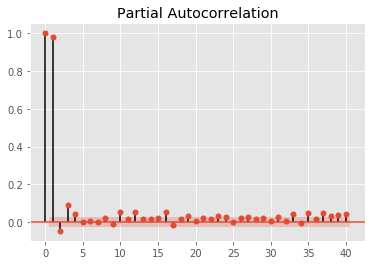

In [9]:
plot_pacf(df_sub.Actual, lags=40)
plt.show()

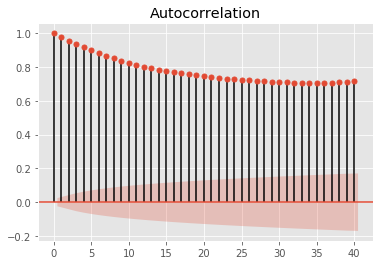

In [10]:
plot_acf(df_sub.Actual, lags=40)
plt.show()

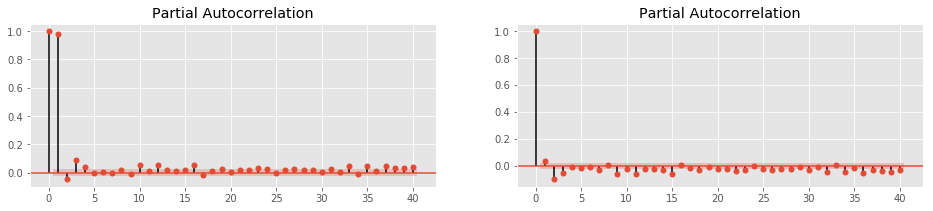

In [11]:
# one differencing pacf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_sub.Actual, lags=40, ax=axes[0])
plot_pacf(df_sub.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

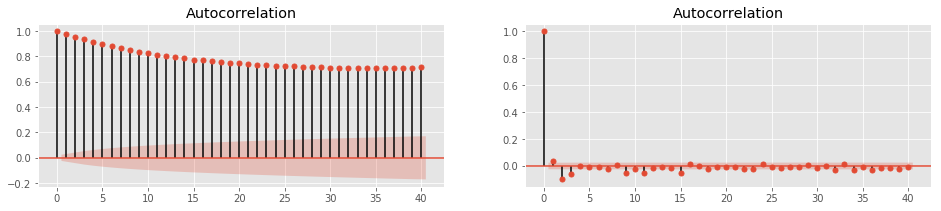

In [12]:
# one differencing acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_acf(df_sub.Actual, lags=40, ax=axes[0])
plot_acf(df_sub.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

In [27]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_sub.Actual, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(2, 2)   Log Likelihood              -16704.301
Method:                       css-mle   S.D. of innovations              3.223
Date:                Wed, 19 Aug 2020   AIC                          33420.601
Time:                        20:56:28   BIC                          33461.233
Sample:                    12-23-2019   HQIC                         33434.660
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.7410      2.076      7.581      0.000      11.672      19.810
ar.L1.Actual     1.4490      0.175      8.280      0.000       1.106       1.792
ar.L2.Actual    -0.4579      0.171     -2.67

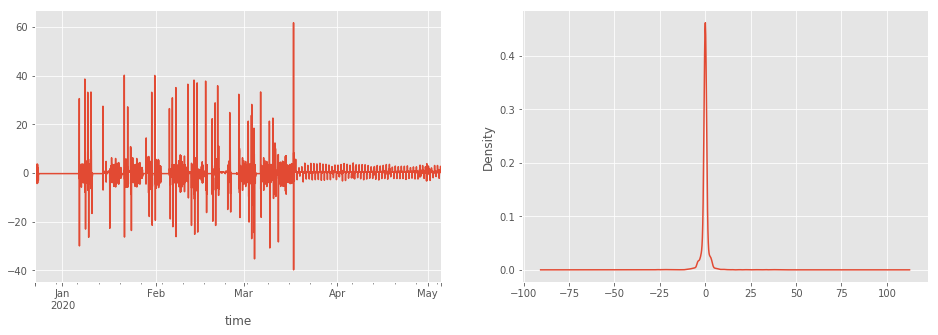

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit.resid.plot(ax=axes[0])
model_fit.resid.plot(kind='kde', ax=axes[1])

In [22]:
df_sub_diff=df_sub.diff()

Text(0, 0.5, 'Wh')

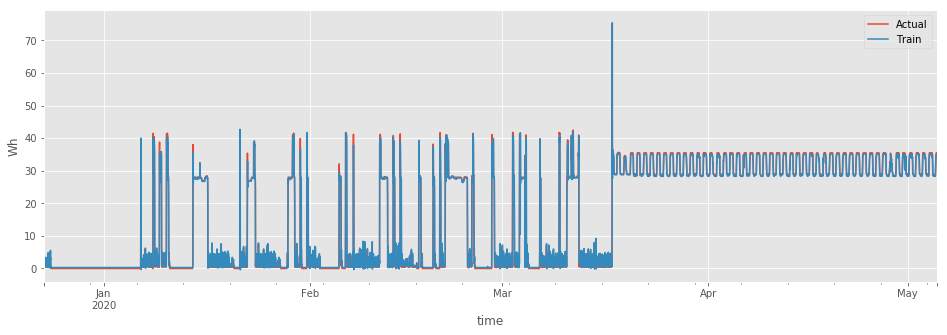

In [29]:
# predict the model
predict= model_fit.predict(dynamic=False)
df_predict= pd.DataFrame(predict, columns=({'Train'}))
df_sub_pred = df_sub.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_sub_pred.set_index(df_sub_pred.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [30]:
next_halfhour=model_fit.forecast(steps=1, exog=None, alpha=0.05)
print(next_halfhour)
print('Actual: ',df_half['Actual'][6451:6452])

(array([35.0902399]), array([3.22272689]), array([[28.77381125, 41.40666854]]))
Actual:  time
2020-05-05 09:30:00    35.5
Freq: 30T, Name: Actual, dtype: float64


In [31]:
mae = np.mean(np.abs(df_sub_pred['Train'] - df_sub_pred['Actual']))
rmse = np.mean((df_sub_pred['Train'] - df_sub_pred['Actual'])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  1.133198047879424 RMSE:  3.227424166263752


In [38]:
# with lockdown
mad_mean_ratio =1.13*6451/(df_sub_pred['Actual']).sum()
mad_mean_ratio

0.07200286459355751